# Contrastive analysis of SA network to ER/BA random networks

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Reading network data and defining certain features of the SA network

In [2]:
G = nx.read_gexf('SA.gexf')
nodes = G.nodes()
edges = G.edges()
N = len(nodes)
L = len(edges)
print(f'Number of nodes in SA network: {N}')
print(f'Number of links in SA network: {L}')
print(f'Average degree of SA network: {2*L/N:.2f}')

Number of nodes in SA network: 1879
Number of links in SA network: 4291
Average degree of SA network: 4.57


Defining random networks with same amount of nodes and same or similar amount of links

In [3]:
G_er = nx.erdos_renyi_graph(N, 2*L/(N*(N-1)))
G_ba = nx.barabasi_albert_graph(N, round(L/N))

Checking initially simply the maximum degrees of all networks

In [4]:
print(f'SA network maximum degree: {max(dict(G.degree()).values())}')
print(f'ER network maximum degree: {max(dict(G_er.degree()).values())}')
print(f'BA network maximum degree: {max(dict(G_ba.degree()).values())}')

SA network maximum degree: 145
ER network maximum degree: 15
BA network maximum degree: 109


Now initially seems clear that SA network is more similar to BA network. Now defining function for plotting data, so this can be verified further

In [5]:
def plot_degree_distribution(G, title=None, log_scale=False):
    k = [degree for _, degree in G.degree()]
    unique_degs = len(np.unique(k))
    n_bins = 30 if unique_degs >= 30 else unique_degs
    if log_scale:
        bins = np.logspace(np.log10(np.min(k)), 
                           np.log10(np.max(k)), 
                           num=n_bins)
        plt.hist(k, density=True, bins=bins)
        plt.xscale('log')
        plt.yscale('log',nonpositive='clip')
    else:
        plt.hist(k, n_bins, density=True)
    plt.title(title)
    plt.xlabel('degree')
    plt.ylabel('%')
    plt.xlim(min(k), max(k))
    plt.show()

Plotting the degree distributions for all the networks

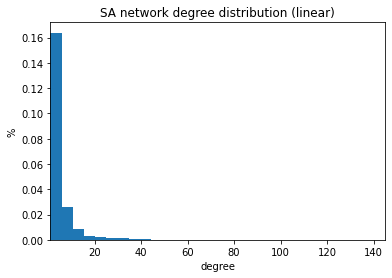

In [6]:
plot_degree_distribution(G, 'SA network degree distribution (linear)', False)

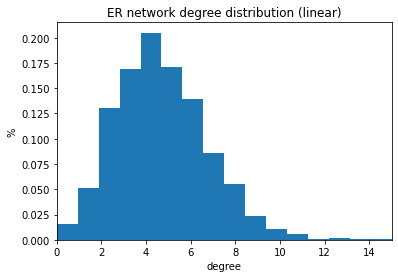

In [7]:
plot_degree_distribution(G_er, 'ER network degree distribution (linear)', False)

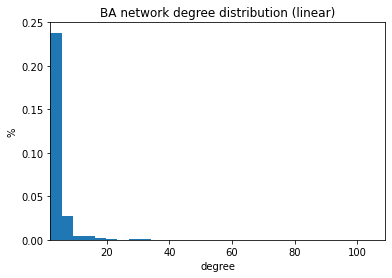

In [8]:
plot_degree_distribution(G_ba, 'BA network degree distribution (linear)', False)

Clearly it seems like the SA network is much more comparable to the scale-free BA network. To confirm this finally we can plot the two networks in log-scale also using log-scale binning.

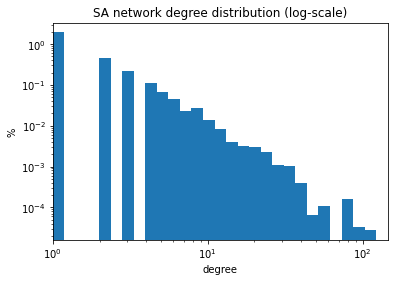

In [9]:
plot_degree_distribution(G, "SA network degree distribution (log-scale)", True)

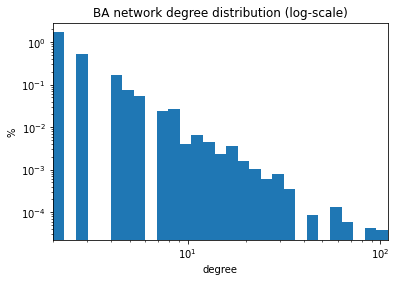

In [10]:
plot_degree_distribution(G_ba, "BA network degree distribution (log-scale)", True)

Now it is clear that they exhibit exhibit extremely similar qualities, so the SeekingAlpha network can be thought of as having scale-free properties.